In [1]:
from dataset import Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import vectorbt as vbt
import plotly.graph_objects as go


#### DEFINE PARAMETERS

In [2]:
TICKERS = ['BTCUSDT', 'ETHUSDT', 'LTCUSDT',
           'BNBUSDT', 'ADAUSDT', 'XRPUSDT', 'DOTUSDT']
TARGET_TIKER = 'BTCUSDT'
FEATURES = ['open', 'high', 'low', 'close', 'volume']
DAYS = 15
TIMEFRAME = '5m'
SPLIT = 0.9

#### Download Dataset

In [3]:
# dataset = Dataset().get_datas(days=DAYS, tickers=TICKERS, ts=TIMEFRAME)
dataset = pd.read_csv('data/dataset_5m_15day_tickers.csv' , index_col=0)
dataset.index = pd.to_datetime(dataset.index)

In [35]:
# save to csv
dataset.to_csv('data/dataset_5m_15day_tickers.csv')

#### Check Dataset

In [4]:
data = dataset.copy()
data['dayOfYear'] = data.index.dayofyear
data.groupby('symbol')\
    .apply(lambda x: x.tail(2))

open        high         low       close  \
symbol  time                                                                  
ADAUSDT 2022-04-25 18:15:00      0.8701      0.8707      0.8684      0.8699   
        2022-04-25 18:20:00      0.8698      0.8706      0.8698      0.8704   
BNBUSDT 2022-04-25 18:15:00    397.9000    398.3000    397.5000    398.2000   
        2022-04-25 18:20:00    398.2000    398.5000    398.2000    398.2000   
BTCUSDT 2022-04-25 18:15:00  39413.8400  39443.6400  39359.9500  39409.9700   
        2022-04-25 18:20:00  39409.9800  39439.2200  39409.9700  39416.9000   
DOTUSDT 2022-04-25 18:15:00     17.6600     17.6700     17.6200     17.6400   
        2022-04-25 18:20:00     17.6400     17.6500     17.6300     17.6400   
ETHUSDT 2022-04-25 18:15:00   2930.7000   2933.6300   2924.7100   2930.2200   
        2022-04-25 18:20:00   2930.2200   2931.8500   2928.8100   2928.9600   
LTCUSDT 2022-04-25 18:15:00    103.0000    103.0000    102.7000    102.9000   
        2022-04-25 18:20:00    102.9000    102.9000    102.8000    102.9000   
XRPUSDT 2022-04-25 18:15:00      0.6733      0.6740      0.6720      0.6730   
        2022-04-25 18:20:00      0.6730      0.6734      0.6729      0.6732   

                                   volume   symbol  dayOfYear  
symbol  time                                                   
ADAUSDT 2022-04-25 18:15:00  188778.20000  ADAUSDT        115  
        2022-04-25 18:20:00   44275.10000  ADAUSDT        115  
BNBUSDT 2022-04-25 18:15:00    1612.52700  BNBUSDT        115  
        2022-04-25 18:20:00     331.61600  BNBUSDT        115  
BTCUSDT 2022-04-25 18:15:00     152.44350  BTCUSDT        115  
        2022-04-25 18:20:00      22.58722  BTCUSDT        115  
DOTUSDT 2022-04-25 18:15:00    4922.97000  DOTUSDT        115  
        2022-04-25 18:20:00    1007.27000  DOTUSDT        115  
ETHUSDT 2022-04-25 18:15:00    1398.37870  ETHUSDT        115  
        2022-04-25 18:20:00     596.76380  ETHUSDT        115  
LTCUSDT 2022-04-25 18:15:00     596.50100  LTCUSDT        115  
        2022-04-25 18:20:00     204.73300  LTCUSDT        115  
XRPUSDT 2022-04-25 18:15:00  542382.00000  XRPUSDT        115  
        2022-04-25 18:20:00   67627.00000  XRPUSDT        115

#### Processing Dataset

In [5]:
df = data.groupby('symbol')\
    .apply(lambda x: x)\
    .assign(target=lambda x: x['close'].shift(-1))\
    .groupby('dayOfYear')\
    .apply(lambda x: x)\
    .dropna()
print(df.head(len(TICKERS)))

                           open        high         low       close  \
time                                                                  
2022-04-10 00:05:00      1.0440      1.0450      1.0400      1.0420   
2022-04-10 00:05:00    426.6000    427.1000    426.0000    426.5000   
2022-04-10 00:05:00  42753.9600  42776.6200  42701.0000  42720.0100   
2022-04-10 00:05:00     19.7600     19.7800     19.6800     19.7200   
2022-04-10 00:05:00   3258.5700   3262.4000   3250.0000   3255.5800   
2022-04-10 00:05:00    112.7000    112.8000    112.4000    112.5000   
2022-04-10 00:05:00      0.7623      0.7631      0.7605      0.7617   

                           volume   symbol  dayOfYear      target  
time                                                               
2022-04-10 00:05:00  385248.70000  ADAUSDT        100      1.0440  
2022-04-10 00:05:00    1773.81400  BNBUSDT        100    427.2000  
2022-04-10 00:05:00      76.82634  BTCUSDT        100  42766.2100  
2022-04-10 00:05:00 

### Split Dataset on train and test data

In [6]:
unique_days = df.dayOfYear.unique()
train_days = unique_days[:int(len(unique_days) * SPLIT)]
test_days = unique_days[int(len(unique_days) * SPLIT):]
train = df[df.dayOfYear.isin(train_days)]
test = df[df.dayOfYear.isin(test_days)]

In [7]:
X_train = train[FEATURES]
y_train = train['target']
X_test = test[FEATURES]
y_test = test['target']
print('train days:', X_train.values.shape)
print('test days:', X_test.values.shape)

train days: (28217, 5)
test days: (3562, 5)


#### Data Transformation
*Rescaling (MinMaxScaler)* - Converts data to a single scale that is between 0 and 1. Increases computational speed for algorithms.

*Standardization (StandardScaler)* - Transforms the data so that it is normally distributed with a mean of 0. Often helps to increase the accuracy of algorithms.

*Normalization (Normalizer)* - Normalization refers to rescaling each observation (row) to have a length of one (called a unit norm or a vector). Thi*s preprocessing method can be useful for sparse datasets of attributes of varying scales when using algorithms that weight input values.

In [8]:
scaler = StandardScaler().fit(X_train)
standardised_X_train = pd.DataFrame(scaler.fit_transform(X_train))
standardised_X_test = pd.DataFrame(scaler.transform(X_test))


#### Create Base model

In [9]:
model = LinearRegression()
model.fit(standardised_X_train, y_train)
y_pred = model.predict(standardised_X_train)
rmse_lin = np.sqrt(mean_squared_error(y_train, y_pred))
r2_lin = r2_score(y_train, y_pred)
print("RMSE for Linear Regression:", rmse_lin)

RMSE for Linear Regression: 22.598899414797394


### Improve model
The primary assumption of Polynomial Regression is that there might exist a non-linear relationship between the features (independent variables) and the target (dependent variable). It is also used when the linear model is unable to capture the trend in the data and gives a poor R² score.

In [10]:
polynomial_features = PolynomialFeatures(degree=2)
x_poly = polynomial_features.fit_transform(X_train)
model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y_train, y_poly_pred))
r2 = r2_score(y_train, y_poly_pred)
print("RMSE for Polynomial Regression:", rmse)


RMSE for Polynomial Regression: 22.482104115496377


#### Tuning model

Text(0.5, 0.98, 'Algorithm Comparison')

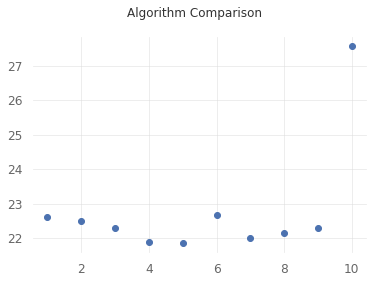

In [11]:
params = np.arange(1, 11)
results = []
names = []
for deg in params:
    polynomial_features = PolynomialFeatures(degree=deg)
    x_poly = polynomial_features.fit_transform(standardised_X_train)
    model = LinearRegression()
    model.fit(x_poly, y_train)
    y_poly_pred = model.predict(x_poly)
    rmse = np.sqrt(mean_squared_error(y_train, y_poly_pred))
    r2 = r2_score(y_train, y_poly_pred)
    results.append(rmse)
    names.append(deg)
plt.plot(names, results, 'o')
plt.suptitle('Algorithm Comparison')


In [12]:
best_degree  = names[[idx for idx, val in enumerate(results) if val == min(results)][0]]
print('Best for train', best_degree)

Best for train 5


In [13]:
model = LinearRegression()
param_grid = {'fit_intercept': [True, False]}
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='r2')
grid.fit(standardised_X_train, y_train)
y_pred = grid.predict(standardised_X_train)
rmse = np.sqrt(mean_squared_error(y_train, y_pred))
print("RMSE for Polynomial Regression:", rmse)
print(grid.best_params_)
print(grid.best_score_)


RMSE for Polynomial Regression: 22.598899414797394
{'fit_intercept': True}
0.9999974210244595


#### Best model

In [14]:
polynomial_features = PolynomialFeatures(degree=best_degree)
x_poly = polynomial_features.fit_transform(standardised_X_train)
model = LinearRegression()
model.fit(x_poly, y_train)
y_poly_pred = model.predict(x_poly)
rmse = np.sqrt(mean_squared_error(y_train, y_poly_pred))
r2 = r2_score(y_train, y_poly_pred)
print("RMSE for Polynomial Regression:", rmse)
print("R2 for Polynomial Regression:", r2)

RMSE for Polynomial Regression: 21.84242532845064
R2 for Polynomial Regression: 0.999997589543447


# Define trading ideas

### Create dataset

In [16]:

train_strategy = train.groupby('symbol')\
    .apply(lambda x: x)\
    .query('symbol == @TARGET_TIKER')\
    .sort_values(by='time')
train_strategy.head(10)

,open,high,low,close,volume,symbol,dayOfYear,target
time,,,,,,,,
2022-04-10 00:05:00,42753.96,42776.62,42701.00,42720.01,76.82634,BTCUSDT,100,42766.21
2022-04-10 00:10:00,42720.00,42771.63,42697.00,42766.21,57.01760,BTCUSDT,100,42722.40
2022-04-10 00:15:00,42766.22,42766.22,42718.03,42722.40,58.52802,BTCUSDT,100,42675.00
2022-04-10 00:20:00,42722.40,42726.70,42669.62,42675.00,51.90298,BTCUSDT,100,42682.47
2022-04-10 00:25:00,42674.99,42717.58,42670.00,42682.47,43.75658,BTCUSDT,100,42720.61
2022-04-10 00:30:00,42682.47,42723.96,42678.79,42720.61,33.29312,BTCUSDT,100,42707.98
2022-04-10 00:35:00,42720.62,42727.99,42696.81,42707.98,32.99800,BTCUSDT,100,42687.75
2022-04-10 00:40:00,42707.99,42707.99,42668.65,42687.75,30.00251,BTCUSDT,100,42671.84
2022-04-10 00:45:00,42687.75,42689.69,42669.11,42671.84,25.42027,BTCUSDT,100,42686.47


#### Calculate SIGMA

In [17]:
polynomial_features = PolynomialFeatures(degree=best_degree)
x_poly = polynomial_features.fit_transform(scaler.transform(train_strategy[FEATURES]))
y_poly_pred = model.predict(x_poly)
y_pred = model.predict(polynomial_features.fit_transform(standardised_X_train))
SIGMA = np.std(y_poly_pred)
print('SIGMA:', SIGMA)

SIGMA: 954.6356459806178


#### Define signal using predict and generalisations

In [18]:
WINDOW = 50

polynomial_features = PolynomialFeatures(degree=best_degree)
x_poly_test = polynomial_features.fit_transform(scaler.transform(train_strategy[FEATURES]))

train_strategy['prediction'] = model.predict(x_poly_test)
# generalisations signal
train_strategy['bottom_line'] = train_strategy['prediction'].rolling(window=WINDOW).min()
train_strategy['upper_line'] = train_strategy['prediction'].rolling(window=WINDOW).max()
# predict signal
train_strategy['signal'] = np.where(train_strategy['close'] < train_strategy['bottom_line'], 1, 0) 
train_strategy['signal'] = np.where(train_strategy['close'] > train_strategy['upper_line'], -1, train_strategy['signal'])

train_strategy['entry_long'] = np.where(train_strategy['signal'] == 1, True, False)
train_strategy['entry_short'] = np.where(train_strategy['signal'] == -1, True, False)

#### Machine Learning Chanel

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_strategy.index,
              y=train_strategy['bottom_line'], name='bottom_line', mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(x=train_strategy.index,
              y=train_strategy['upper_line'],  name='upper_line', mode='lines', line=dict(color='red')))

fig.add_trace(go.Candlestick(x=train_strategy.index,
                             open=train_strategy['open'],
                             high=train_strategy['high'],
                             low=train_strategy['low'],
                             close=train_strategy['close'])
              )


fig.show()


2.5673551976503766e-05


<AxesSubplot:xlabel='time'>

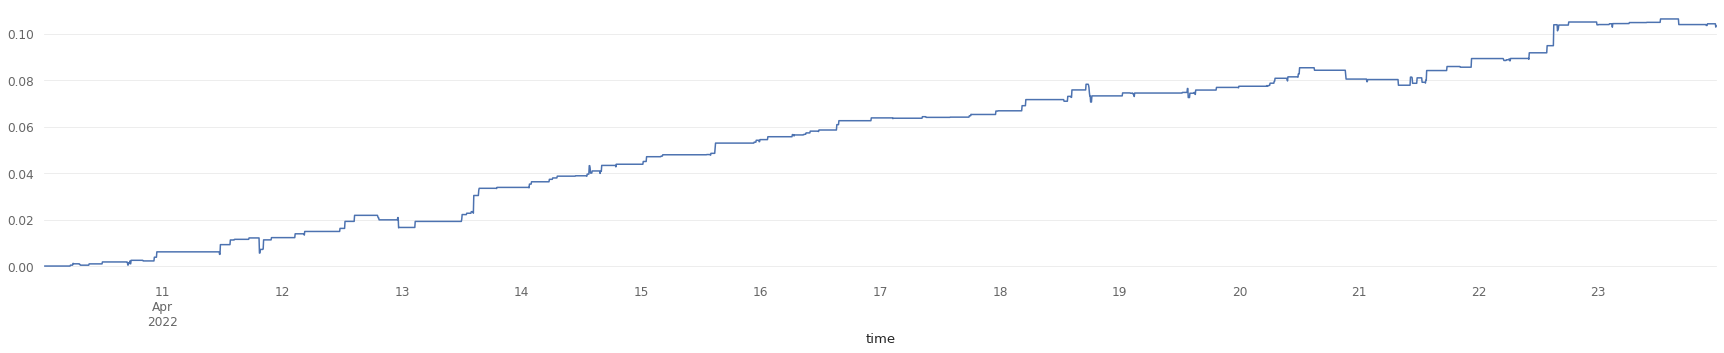

In [20]:
train_strategy['returns'] = train_strategy['signal'] * \
    train_strategy['close'].pct_change().shift(-1)
print(train_strategy['returns'].mean())
train_strategy['cum_returns'] = train_strategy['returns'].cumsum()
train_strategy['cum_returns'].plot(figsize=(30, 5))


-1    2054
 1    1977
Name: pred_dir, dtype: int64
0.00010852869528693275


<AxesSubplot:xlabel='time'>

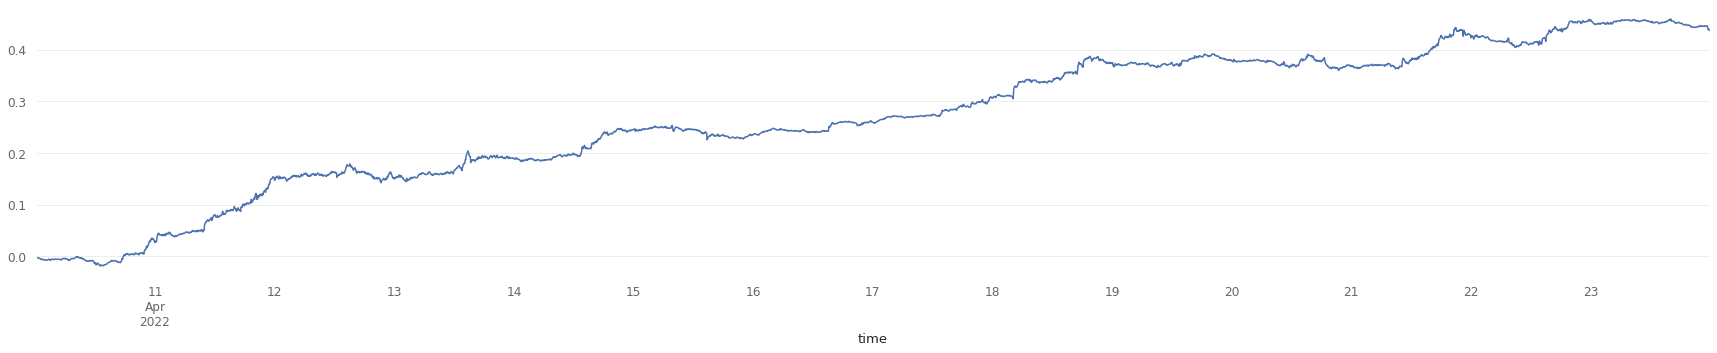

In [21]:
train_strategy['pred_dir'] = np.where(
    train_strategy['prediction'] > train_strategy['close'], 1, -1)
print(train_strategy['pred_dir'].value_counts())
train_strategy['returns_strategy_pred'] = train_strategy['pred_dir'] * \
    train_strategy['close'].pct_change().shift(-1)
print(train_strategy['returns_strategy_pred'].mean())
train_strategy['cum_returns_strategy_pred'] = train_strategy['returns_strategy_pred'].cumsum()
train_strategy['cum_returns_strategy_pred'].plot(figsize=(30, 5))


In [22]:
test_strategy = test.groupby('symbol')\
    .apply(lambda x: x)\
    .query('symbol == @TARGET_TIKER')
test_strategy.head(10)

,open,high,low,close,volume,symbol,dayOfYear,target
time,,,,,,,,
2022-04-24 00:00:00,39419.57,39472.61,39411.11,39441.60,108.98220,BTCUSDT,114,39491.36
2022-04-24 00:05:00,39441.61,39537.14,39414.18,39491.36,220.52743,BTCUSDT,114,39513.87
2022-04-24 00:10:00,39491.37,39533.88,39464.02,39513.87,61.89212,BTCUSDT,114,39547.88
2022-04-24 00:15:00,39513.86,39570.11,39513.86,39547.88,99.36231,BTCUSDT,114,39544.06
2022-04-24 00:20:00,39547.88,39564.98,39516.27,39544.06,83.40986,BTCUSDT,114,39546.45
2022-04-24 00:25:00,39544.07,39551.31,39518.01,39546.45,47.04267,BTCUSDT,114,39637.92
2022-04-24 00:30:00,39546.46,39637.92,39546.45,39637.92,228.03184,BTCUSDT,114,39607.60
2022-04-24 00:35:00,39637.92,39654.56,39607.59,39607.60,53.81905,BTCUSDT,114,39639.32
2022-04-24 00:40:00,39607.59,39643.13,39595.10,39639.32,64.67224,BTCUSDT,114,39621.66


In [23]:
WINDOW = 50

polynomial_features = PolynomialFeatures(degree=best_degree)
x_poly_test = polynomial_features.fit_transform(scaler.transform(test_strategy[FEATURES]))

test_strategy['prediction'] = model.predict(x_poly_test)
test_strategy['bottom_line'] = test_strategy['prediction'].rolling(window=WINDOW).min()
test_strategy['upper_line'] = test_strategy['prediction'].rolling(window=WINDOW).max()
test_strategy['signal'] = np.where(test_strategy['close'] < test_strategy['bottom_line'], 1, 0) 
test_strategy['signal'] = np.where(test_strategy['close'] > test_strategy['upper_line'], -1, test_strategy['signal'])
test_strategy['entry_long'] = np.where(test_strategy['signal'] == 1, True, False)
test_strategy['entry_short'] = np.where(test_strategy['signal'] == -1, True, False)

In [24]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_strategy.index,
              y=test_strategy['bottom_line'], name='bottom_line', mode='lines', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test_strategy.index,
              y=test_strategy['upper_line'],  name='upper_line', mode='lines', line=dict(color='red')))

fig.add_trace(go.Candlestick(x=test_strategy.index,
                             open=test_strategy['open'],
                             high=test_strategy['high'],
                             low=test_strategy['low'],
                             close=test_strategy['close'])
              )


fig.show()


3.898262020658902e-05


<AxesSubplot:xlabel='time'>

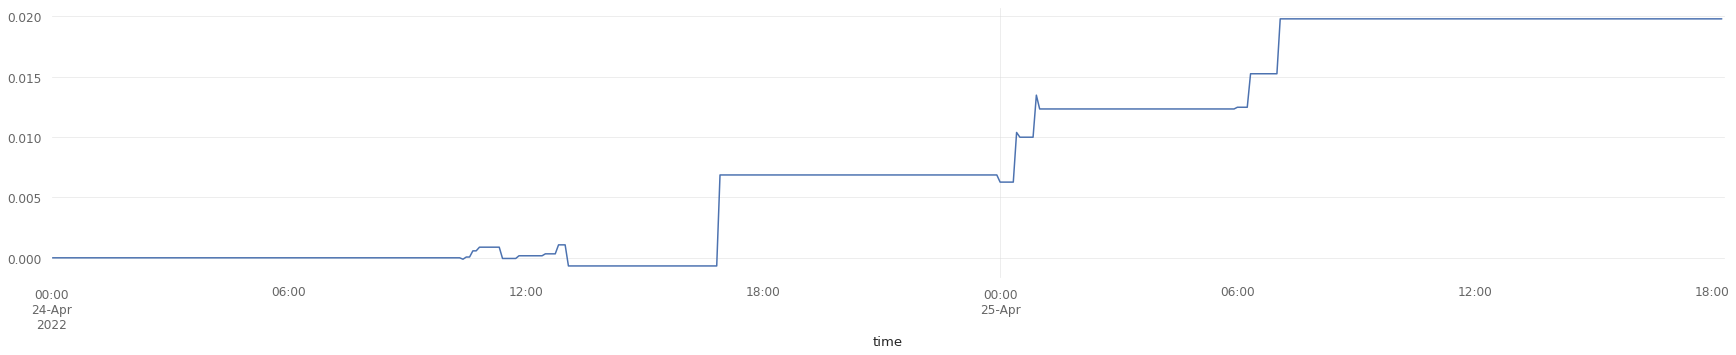

In [25]:
test_strategy['returns'] = test_strategy['signal'] * test_strategy['close'].pct_change().shift(-1)
print(test_strategy['returns'].mean())
test_strategy['cum_returns'] = test_strategy['returns'].cumsum()
test_strategy['cum_returns'].plot(figsize=(30, 5))

#### Test Signal strategy using predict direction
* effect data leak with open price data

 1    349
-1    160
Name: pred_dir, dtype: int64
0.00010897319731166783


<AxesSubplot:xlabel='time'>

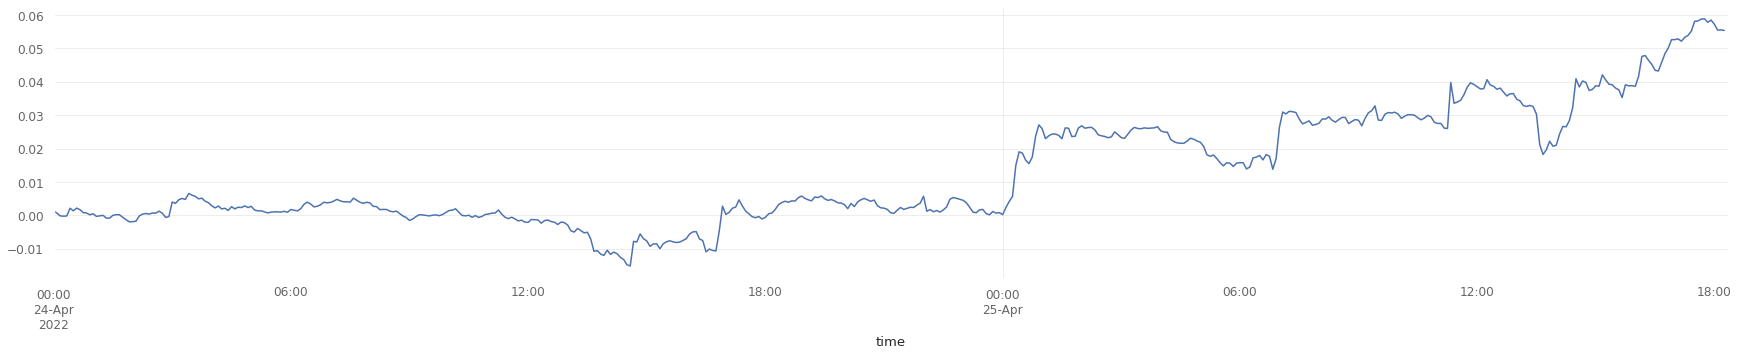

In [26]:
test_strategy['pred_dir'] = np.where(
    test_strategy['prediction'] > test_strategy['close'], 1, -1)
print(test_strategy['pred_dir'].value_counts())
test_strategy['returns_strategy_pred'] = test_strategy['pred_dir'] * \
    test_strategy['close'].pct_change().shift(-1)
print(test_strategy['returns_strategy_pred'].mean())
test_strategy['cum_returns_strategy_pred'] = test_strategy['returns_strategy_pred'].cumsum()
test_strategy['cum_returns_strategy_pred'].plot(figsize=(30, 5))


Text(0.5, 0.98, 'Algorithm Comparison')

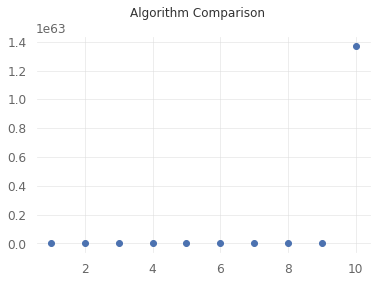

In [48]:
params = np.arange(1, 11)
results_test = []
names_test = []
for deg in params:
    polynomial_features = PolynomialFeatures(degree=deg)
    x_poly = polynomial_features.fit_transform(standardised_X_train)
    model = LinearRegression()
    model.fit(x_poly, y_train)
    x_poly_test = polynomial_features.fit_transform(X_test)
    y_poly_pred_test = model.predict(x_poly_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_poly_pred_test))
    r2 = r2_score(y_test, y_poly_pred_test)
    results_test.append(rmse)
    names_test.append(deg)
plt.plot(names_test, results_test, 'o')
plt.suptitle('Algorithm Comparison')


In [49]:
print('Best for test', names_test[[idx for idx, val in enumerate(results_test) if val == min(results_test)][0]])


Best for test 1
